In [1]:
# Initial imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, cohen_kappa_score
from sklearn.metrics import RocCurveDisplay, roc_auc_score, auc, roc_curve

import time
from kappa_score import qwkappa

from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
# read in test and train data from S3
import pandas as pd
orig_test = pd.read_csv("https://project4-wine-quality-2023.s3.us-west-2.amazonaws.com/test.csv")
orig_train = pd.read_csv("https://project4-wine-quality-2023.s3.us-west-2.amazonaws.com/train.csv")

In [3]:
# Drop 'ID' columns
orig_test = orig_test.drop(columns='Id')
orig_train = orig_train.drop(columns='Id')

# Create a place to save any generated files
rf_roc_output_path = os.path.join('../random forest output','ROC_AUC')
os.makedirs(rf_roc_output_path, exist_ok = True)

In [4]:
# Split the data into training and testing sets
X_train = orig_train.drop('quality', axis=1)
y_train = orig_train['quality'].copy()
X_test = orig_test.copy()
quality_rating = list(y_train)
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  stratify= quality_rating,
                                                  test_size = 0.2, 
                                                  random_state = 42) #because it is the answer :) thank you for the fish

In [5]:
# Create a Random Forest Regressor
model = RandomForestClassifier()

# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [30],
    # 'learning_rate': [0.05],
    'max_depth': [2]
}

# Use stratified k-fold cross-validation
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform grid search with cross-validation
start_time = time.time()
grid_search = GridSearchCV(model, param_grid, cv=skfold, verbose=3)
grid_search.fit(X_train, y_train)

# Get the most model from grid search
most_rf = grid_search.best_estimator_
grid_search_time = time.time()

# Make predictions on the test data using the best model
y_pred = most_rf.predict(X_val)
y_score = most_rf.predict_proba(X_val) # this line is needed to create ROC charts

# Report how long it took to complete Grid search and prediction
end_time = time.time()
grid_time = grid_search_time - start_time
pred_time = end_time - grid_search_time
tot_time = end_time - start_time


print("--------------------------------------------------------------------------------------------------")
print()
print(f"Time to complete Grid Search: {grid_time:.6f} seconds")
print(f"Time to complete prediction: {pred_time:.6f} seconds")
print(f"Total time to complete Grid Search and prediction: {tot_time:.6f} seconds")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ......max_depth=2, n_estimators=30;, score=0.565 total time=   0.0s
[CV 2/5] END ......max_depth=2, n_estimators=30;, score=0.532 total time=   0.0s
[CV 3/5] END ......max_depth=2, n_estimators=30;, score=0.544 total time=   0.0s
[CV 4/5] END ......max_depth=2, n_estimators=30;, score=0.596 total time=   0.0s
[CV 5/5] END ......max_depth=2, n_estimators=30;, score=0.540 total time=   0.0s
--------------------------------------------------------------------------------------------------

Time to complete Grid Search: 0.273814 seconds
Time to complete prediction: 0.005999 seconds
Total time to complete Grid Search and prediction: 0.279813 seconds


In [6]:
# Calculate metrics
accuracy = accuracy_score(y_val, y_pred)
# the following metrics need to include the average type since the validation is ordinal and not binary
f1 = f1_score(y_val, y_pred, average= 'weighted')
precision = precision_score(y_val, y_pred, average= 'weighted')
recall = recall_score(y_val, y_pred, average= 'weighted')
kappa = cohen_kappa_score(y_val, y_pred, weights='quadratic')

print(f"Model scores with stratify and skf:")
print("-------------------")
print(f"Best Estimators: {most_rf.n_estimators}")
# print(f"Best Learning Rate: {best_rf.learning_rate}")
print(f"Best Max Depth: {most_rf.max_depth}")
print(f"Accuracy: {accuracy:.2f}")
print(f"F1: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Cohen Kappa Score, quadratic weighted: {kappa:.4f}")

Model scores with stratify and skf:
-------------------
Best Estimators: 30
Best Max Depth: 2
Accuracy: 0.59
F1: 0.52
Precision: 0.47
Recall: 0.59
Cohen Kappa Score, quadratic weighted: 0.4455


In [7]:
print("--------------------------------------------------------")
print(f"Gradient Boost Model with stratify and statified k-fold activated:")
# print(f"     Learning Rate =   {most_rf.learning_rate}")
print(f"     Number of Trees = {most_rf.n_estimators}")
print(f"     Max Tree Depth =  {most_rf.max_depth}")
print("--------------------------------------------------------")
print(f"Classification Report")
print(classification_report(y_val,y_pred))
print("--------------------------------------------------------")
print(f"Quadratic Weighted Kappa Score: {kappa:.4f}")
print("--------------------------------------------------------")
print()
print(f"Time to complete run model: {grid_time:.6f} seconds")
print(f"Time to complete prediction: {pred_time:.6f} seconds")
print(f"Total time to complete model and prediction: {tot_time:.6f} seconds")
print()
print("--------------------------------------------------------")

--------------------------------------------------------
Gradient Boost Model with stratify and statified k-fold activated:
     Number of Trees = 30
     Max Tree Depth =  2
--------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        11
           5       0.69      0.77      0.73       168
           6       0.50      0.72      0.59       156
           7       0.00      0.00      0.00        67
           8       0.00      0.00      0.00         8

    accuracy                           0.59       412
   macro avg       0.20      0.25      0.22       412
weighted avg       0.47      0.59      0.52       412

--------------------------------------------------------
Quadratic Weighted Kappa Score: 0.4455
--------------------------------------------------------

Time to complete run model: 0.273814 seconds
Time

In [8]:
# Below this cell content from"
# https://github.com/vinyluis/Articles/blob/main/ROC%20Curve%20and%20ROC%20AUC/ROC%20Curve%20-%20Multiclass.ipynb
def calculate_tpr_fpr(y_val, y_pred):
    
    # Calculates the confusion matrix and recover each element
    cm = confusion_matrix(y_val, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]
    
    # Calculates tpr and fpr
    tpr =  TP/(TP + FN) # sensitivity - true positive rate
    fpr = 1 - TN/(TN+FP) # 1-specificity - false positive rate
    
    return tpr, fpr  # tpr: The True Positive Rate of the classifier /  fpr: The False Positive Rate of the classifier

def get_all_roc_coordinates(y_val, y_pred):
    
    # Calculates all the ROC Curve coordinates (tpr and fpr) by considering each point as a threshold for the predicion of the class.  
    tpr_list = [0]
    fpr_list = [0]
    for i in range(len(y_pred)):
        threshold = y_pred[i]
        y_predict = y_pred >= threshold
        tpr, fpr = calculate_tpr_fpr(y_val, y_predict)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
         
    return tpr_list, fpr_list   # tpr_list: The list of TPRs representing each threshold.  /   fpr_list: The list of FPRs representing each threshold.


def plot_roc_curve(tpr, fpr, scatter = True, ax = None):
    
    # Plots the ROC Curve by using the list of coordinates (tpr and fpr).
    
    # Args:
    #     tpr: The list of TPRs representing each coordinate.
    #     fpr: The list of FPRs representing each coordinate.
    #     scatter: When True, the points used on the calculation will be plotted with the line (default = True).
     
    if scatter:
        sns.scatterplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = fpr, y = tpr, color = 'darkorange',ax = ax)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

OSError: [Errno 22] Invalid argument: '../random forest output\\ROC_AUC/ROC-OvR n-est:30 depth:2 kappa=0.4455.png'

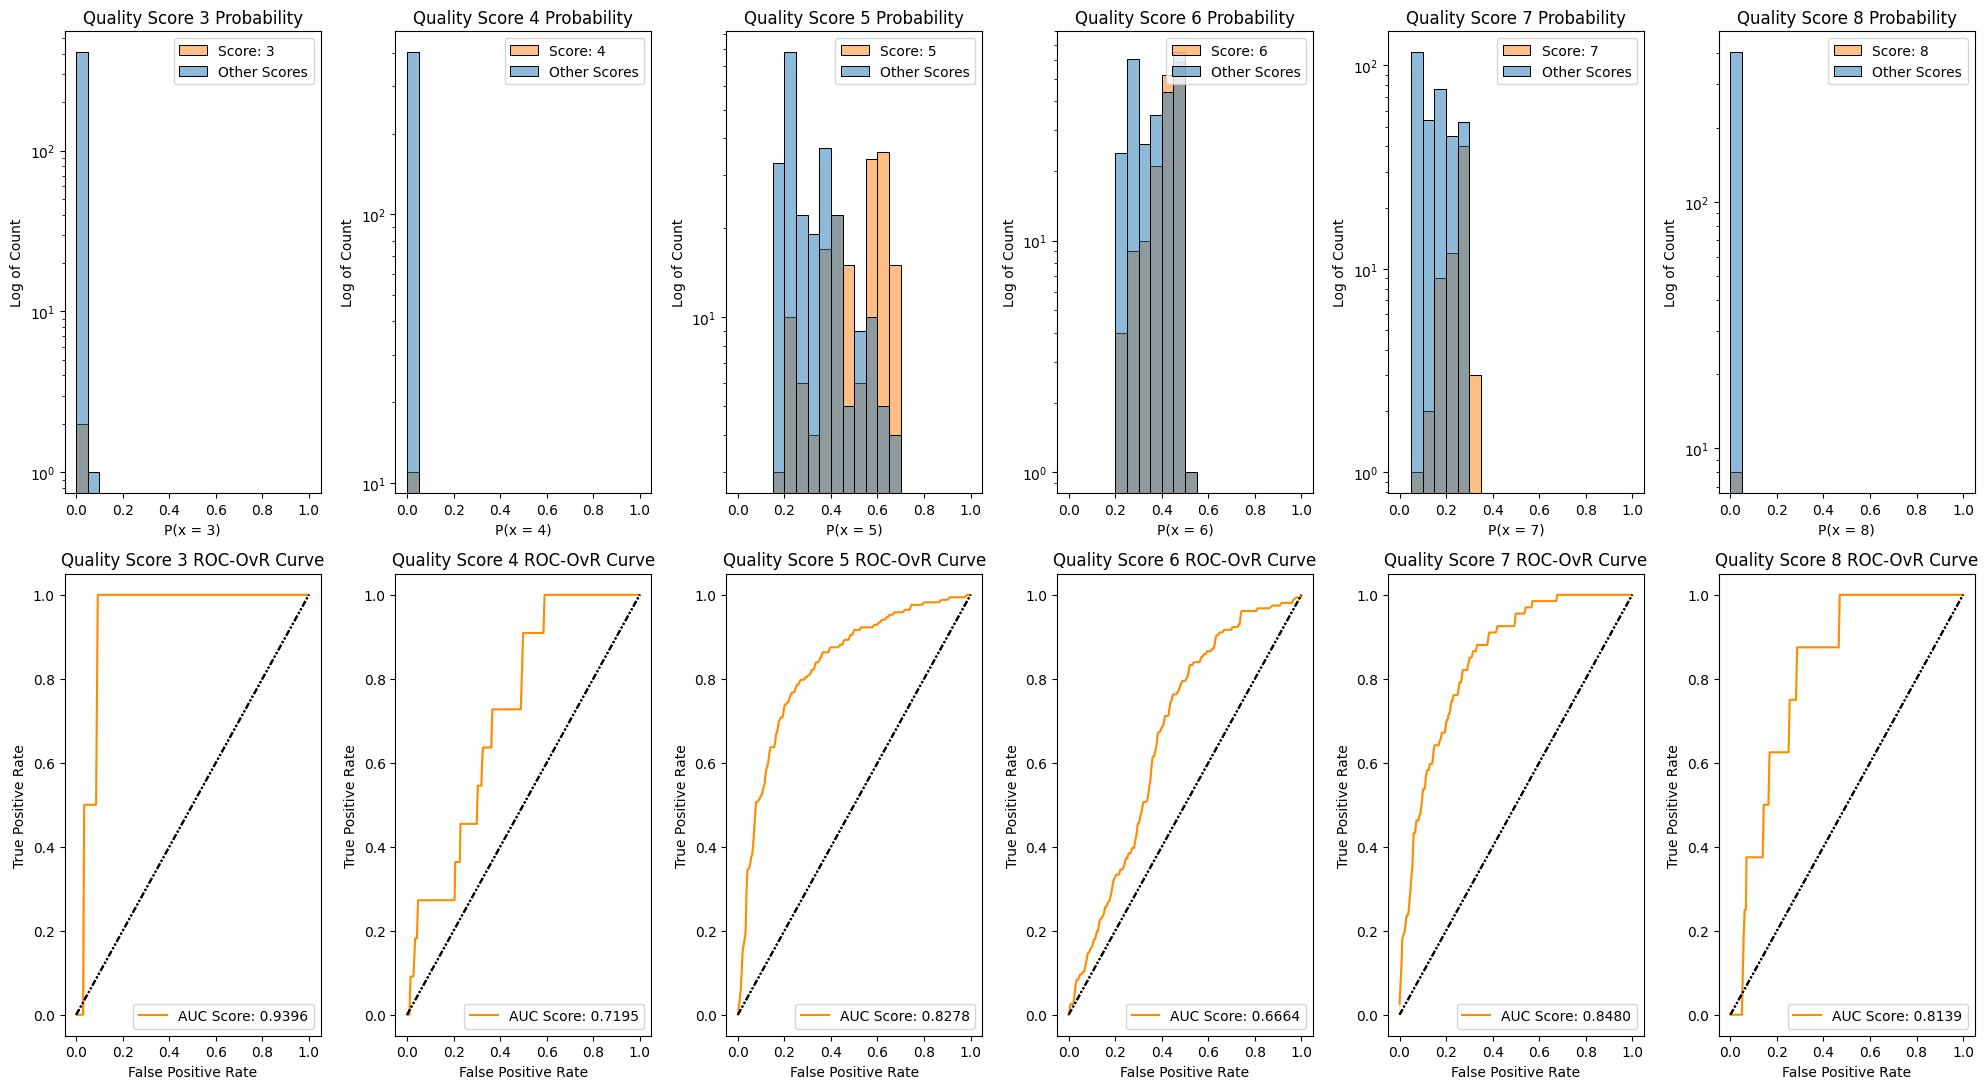

In [9]:
# Plots the Probability Distributions and the ROC Curves One vs Rest
plt.figure(figsize = (20, 11))
bins = [i/20 for i in range(20)] + [1]
classes = most_rf.classes_
roc_auc_ovr = {}
for i in range(len(classes)):
    # Gets the class
    c = classes[i]
    
    # Prepares an helper dataframe to generate plots
    # converts multi class into binary c onfusion matrix to calculate fpr and tpr
    df_aux = X_val.copy()
    df_aux['class'] = [1 if y == c else 0 for y in y_val]
    df_aux['prob'] = y_score[:, i]
    df_aux = df_aux.reset_index(drop = True)

    # Calculates the ROC AUC OvR
    roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])
    
    # Plots the probability distribution for the class and the rest
    ax = plt.subplot(2, len(classes) , i+1) # generate plots in a grid of 2 rows and as many columns as classes starting in row 1 (+1 because it is zero based)
    sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'darkorange', ax = ax, bins = bins)
    ax.set_title(f"Quality Score {c} Probability")
    ax.set_yscale("log")
    ax.legend([f"Score: {c}", "Other Scores"])
    ax.set_xlabel(f"P(x = {c})")
    ax.set_ylabel("Log of Count")
    
    # Calculates the ROC Coordinates and plots the ROC Curves
    ax_bottom = plt.subplot(2, len(classes), i+len(classes)+1) # i+len(classes)+1 will make a new plot on the next row so it will not overlay on the histograms 
    tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
    plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)

    plt.plot([[0, 0],[1, 1]], color = 'black', linestyle = (0, (3, 1, 1, 1, 1, 1)), label ="Chance level (AUC: 0.5)") # draws line from (0,0) to (1,1) to show AUC score 0.5 (i.e. pure chance)
    ax_bottom.set_title(f"Quality Score {c} ROC-OvR Curve")
    ax_bottom.legend([f"AUC Score: {roc_auc_ovr[c]:.4f}"],loc = 'lower right')
        
plt.tight_layout()

# Save and show the figure
output_filename = f"{rf_roc_output_path}/ROC-OvR n-est:{most_rf.n_estimators} depth:{most_rf.max_depth} kappa={kappa:.4f}.png"
plt.savefig(output_filename)
plt.show()

In [10]:
# Create all of the comparisons for OvO analysis
# Note: in the [m,n] pair, m= correct answer and n= incorrect answer. So the pair [m,n] is not the same as [n,m] for the OvO comparison

classes_combo = []
class_list = list(classes)
for i in range(len(class_list)):
    for j in range(i+1, len(class_list)):
        classes_combo.append([class_list[i], class_list[j]])
        classes_combo.append([class_list[j], class_list[i]])


KeyError: 0.4454814745157043

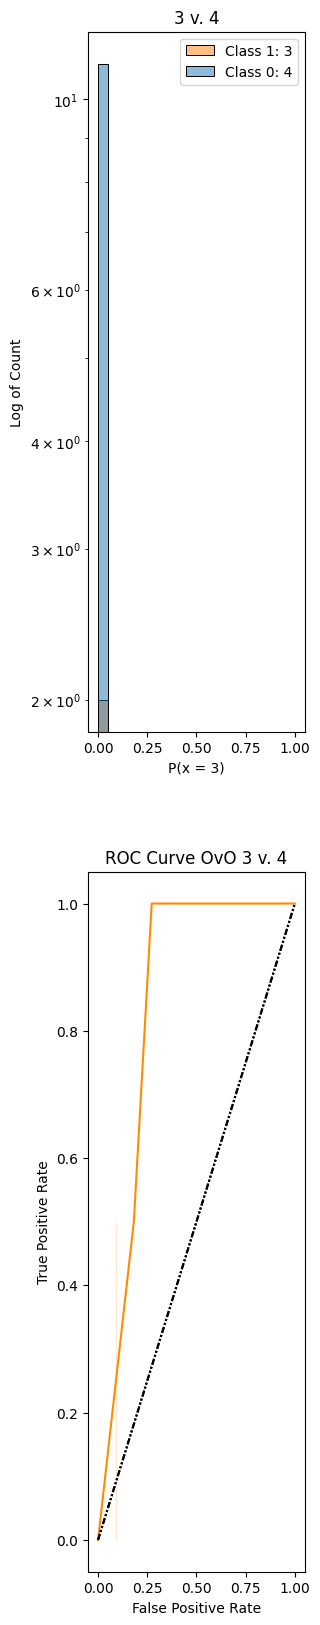

In [11]:
# Plots the Probability Distributions and the ROC Curves One vs ONe
plt.figure(figsize = (100, 20))
bins = [i/20 for i in range(20)] + [1]
roc_auc_ovo = {}

for i in range(len(classes_combo)):
    # Gets the class
    comb = classes_combo[i]
    c1 = comb[0]
    c2 = comb[1]
    c1_index = class_list.index(c1)
    title = f"{c1} v. {c2}"
    
    # Prepares an auxiliar dataframe to help with the plots
    df_aux = X_val.copy()
    df_aux['class'] = y_val
    df_aux['prob'] = y_score[:, c1_index]
    
    # Slices only the subset with both classes
    df_aux = df_aux[(df_aux['class'] == c1) | (df_aux['class'] == c2)]
    df_aux['class'] = [1 if y == c1 else 0 for y in df_aux['class']]
    df_aux = df_aux.reset_index(drop = True)
    
    # Plots the probability distribution for the class and the rest
    ax = plt.subplot(2, len(classes_combo), i+1)
    sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'darkorange', ax = ax, bins = bins)
    ax.set_title(title)
    ax.set_yscale("log") ##
    ax.legend([f"Class 1: {c1}", f"Class 0: {c2}"])
    ax.set_xlabel(f"P(x = {c1})")
    ax.set_ylabel("Log of Count") ##

    
    # Calculates the ROC Coordinates and plots the ROC Curves
    ax_bottom = plt.subplot(2, len(classes_combo) , i+len(classes_combo)+1)
    tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
    plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
    ax_bottom.set_title(f"ROC Curve OvO {c1} v. {c2}")
    
    # Calculates the ROC AUC OvO
    roc_auc_ovo[title] = roc_auc_score(df_aux['class'], df_aux['prob'])
    plt.plot([[0, 0],[1, 1]], color = 'black', linestyle = (0, (3, 1, 1, 1, 1, 1)), label ="Chance level (AUC: 0.5)") # draws line from (0,0) to (1,1) to show AUC score 0.5 (i.e. pure chance)
    ax_bottom.legend([f"AUC Score: {roc_auc_ovo[kappa]:.4f}"],loc = 'lower right')
    
plt.tight_layout()

# Save and show the figure
output_filename = f"{rf_roc_output_path}/ROC-OvO n-est:{most_rf.n_estimators} depth:{most_rf.max_depth} kappa={kappa:.4f}.png"
plt.savefig(output_filename)
plt.show()

In [12]:
# Displays the ROC AUC for each class
avg_roc_auc = 0
i = 0
for k in roc_auc_ovo:
    avg_roc_auc += roc_auc_ovo[k]
    i += 1
    print(f"{k} ROC AUC OvO: {roc_auc_ovo[k]:.4f}")
print(f"average ROC AUC OvO: {avg_roc_auc/i:.4f}")

3 v. 4 ROC AUC OvO: 0.8409
average ROC AUC OvO: 0.8409


In [13]:
confusion_matrix(y_val, y_pred)

array([[  0,   0,   1,   1,   0,   0],
       [  0,   0,   8,   3,   0,   0],
       [  0,   0, 129,  39,   0,   0],
       [  0,   0,  43, 113,   0,   0],
       [  0,   0,   5,  62,   0,   0],
       [  0,   0,   0,   8,   0,   0]], dtype=int64)

In [14]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        11
           5       0.69      0.77      0.73       168
           6       0.50      0.72      0.59       156
           7       0.00      0.00      0.00        67
           8       0.00      0.00      0.00         8

    accuracy                           0.59       412
   macro avg       0.20      0.25      0.22       412
weighted avg       0.47      0.59      0.52       412

